In [233]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [234]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

In [235]:
def generate_a_drawing(figsize, U, V, noise=0.0):
  fig = plt.figure(figsize=(figsize,figsize))
  ax = plt.subplot(111)
  plt.axis('Off')
  ax.set_xlim(0,figsize)
  ax.set_ylim(0,figsize)
  ax.fill(U, V, "k")
  fig.canvas.draw()
  imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
  imdata = imdata + noise * np.random.random(imdata.size)
  plt.close(fig)
  return imdata

In [236]:
def generate_a_rectangle(noise=0.0, free_location=False):
  figsize = 1.0
  U = np.zeros(4)
  V = np.zeros(4)
  if free_location:
    corners = np.random.random(4)
    top = max(corners[0], corners[1])
    bottom = min(corners[0], corners[1])
    left = min(corners[2], corners[3])
    right = max(corners[2], corners[3])
  else:
    side = (0.3 + 0.7 * np.random.random()) * figsize
    top = figsize/2 + side/2
    bottom = figsize/2 - side/2
    left = bottom
    right = top
  U[0] = U[1] = top
  U[2] = U[3] = bottom
  V[0] = V[3] = left
  V[1] = V[2] = right
  return generate_a_drawing(figsize, U, V, noise)

In [237]:
def generate_a_disk(noise=0.0, free_location=False):
  figsize = 1.0
  if free_location:
    center = np.random.random(2)
  else:
    center = (figsize/2, figsize/2)
  radius = (0.3 + 0.7 * np.random.random()) * figsize/2
  N = 50
  U = np.zeros(N)
  V = np.zeros(N)
  i = 0
  for t in np.linspace(0, 2*np.pi, N):
    U[i] = center[0] + np.cos(t) * radius
    V[i] = center[1] + np.sin(t) * radius
    i = i + 1
  return generate_a_drawing(figsize, U, V, noise)

In [238]:
def generate_a_triangle(noise=0.0, free_location=False):
  figsize = 1.0
  if free_location:
    U = np.random.random(3)
    V = np.random.random(3)
  else:
    size = (0.3 + 0.7 * np.random.random())*figsize/2
    middle = figsize/2
    U = (middle, middle+size, middle-size)
    V = (middle+size, middle-size, middle-size)
  imdata = generate_a_drawing(figsize, U, V, noise)
  return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

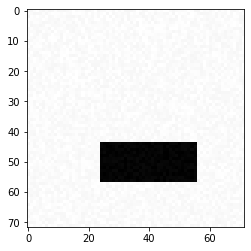

In [239]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

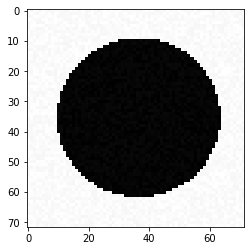

In [240]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

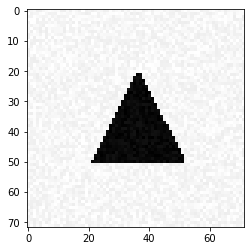

In [241]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

In [242]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
  # Getting im_size:
  im_size = generate_a_rectangle().shape[0]
  X = np.zeros([nb_samples, im_size])
  Y = np.zeros(nb_samples)
  print('Creating data:')
  for i in range(nb_samples):
    if i % 10 == 0:
      print(i)
    category = np.random.randint(3)
    if category == 0:
      X[i] = generate_a_rectangle(noise, free_location)
    elif category == 1:
      X[i] = generate_a_disk(noise, free_location)
    else:
      [X[i], V] = generate_a_triangle(noise, free_location)
    Y[i] = category
  X = (X + noise) / (255 + 2 * noise)
  return [X, Y]

In [243]:
def generate_test_set_classification():
  np.random.seed(42)
  [X_test, Y_test] = generate_dataset_classification(300, 20, True)
  Y_test = np_utils.to_categorical(Y_test, 3)
  return [X_test, Y_test]

In [244]:
def generate_dataset_regression(nb_samples, noise=0.0):
  # Getting im_size:
  im_size = generate_a_triangle()[0].shape[0]
  X = np.zeros([nb_samples, im_size])
  Y = np.zeros([nb_samples, 6])
  print('Creating data:')
  for i in range(nb_samples):
    if i % 10 == 0:
      print(i)
    [X[i], Y[i]] = generate_a_triangle(noise, True)
  X = (X + noise) / (255 + 2 * noise)
  return [X, Y]

In [245]:
def visualize_prediction(x, y):
  fig, ax = plt.subplots(figsize=(5, 5))
  I = x.reshape((IMAGE_SIZE, IMAGE_SIZE))
  ax.imshow(I, extent=[-0.15, 1.15, -0.15, 1.15], cmap='gray')
  ax.set_xlim([0, 1])
  ax.set_ylim([0, 1])

  xy = y.reshape(3, 2)
  tri = patches.Polygon(xy, closed=True, fill=False,
                        edgecolor='r', linewidth=5, alpha=0.5)
  ax.add_patch(tri)

  plt.show()

In [246]:
def generate_test_set_regression():
  np.random.seed(42)
  [X_test, Y_test] = generate_dataset_regression(300, 20)
  return [X_test, Y_test]

In [247]:
from tensorflow import keras
from tensorflow.keras import utils as np_utils

1.

In [248]:
X_train, Y_train = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


2.

3.

In [249]:
X_test, Y_test = generate_dataset_classification(300, 20, True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


4.

In [250]:
X_test, Y_test = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [255]:
# visualize_prediction
# generate_dataset_regression
# generate_test_set_regression